In [26]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as pjoin
import sys
from sklearn.metrics import r2_score
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
import time
from sklearn.neural_network import MLPRegressor


import matplotlib

font = {"size": 20}
matplotlib.rc("font", **font)
matplotlib.rcParams["text.usetex"] = True


sys.path.append("../../prrr/models/")
from grrr import GRRR
from prrr import PRRR
from gaussian_rrr import GaussianRRR

In [12]:
n_list = [100, 200, 1_000]
q_list = [10, 50, 300]

In [23]:

## Create synthetic data
n = 1000
p = 20
q = 20
r_true = 3
USE_VI = False

data_generating_model = "PRRR"

n_repeats = 2
results_prrr = np.zeros((n_repeats, len(n_list)))
results_grrr = np.zeros((n_repeats, len(n_list)))
results_gaussrrr = np.zeros((n_repeats, len(n_list)))
results_fullrank = np.zeros((n_repeats, len(n_list)))
results_nn = np.zeros((n_repeats, len(n_list)))


def centered_r2_score(y_test, preds):
    return r2_score(y_test - y_test.mean(0), preds - preds.mean(0))


def _fit_rrr_no_intercept_all_ranks(
    X: np.ndarray, Y: np.ndarray, alpha: float, solver: str
):
    ridge = sklearn.linear_model.Ridge(alpha=alpha, fit_intercept=False, solver=solver)
    beta_ridge = ridge.fit(X, Y).coef_
    Lambda = np.eye(X.shape[1]) * np.sqrt(np.sqrt(alpha))
    X_star = np.concatenate((X, Lambda))
    Y_star = X_star @ beta_ridge.T
    _, _, Vt = np.linalg.svd(Y_star, full_matrices=False)
    return beta_ridge, Vt


def _fit_rrr_no_intercept(
    X: np.ndarray, Y: np.ndarray, alpha: float, rank: int, solver: str, memory=None
):
    memory = sklearn.utils.validation.check_memory(memory)
    fit = memory.cache(_fit_rrr_no_intercept_all_ranks)
    beta_ridge, Vt = fit(X, Y, alpha, solver)
    return Vt[:rank, :].T @ (Vt[:rank, :] @ beta_ridge)


class ReducedRankRidge(
    sklearn.base.MultiOutputMixin,
    sklearn.base.RegressorMixin,
    sklearn.linear_model._base.LinearModel,
):
    def __init__(
        self, alpha=1.0, fit_intercept=True, rank=None, ridge_solver="auto", memory=None
    ):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.rank = rank
        self.ridge_solver = ridge_solver
        self.memory = memory

    def fit(self, X, y):
        if self.fit_intercept:
            X_offset = np.average(X, axis=0)
            y_offset = np.average(y, axis=0)
            # doesn't modify inplace, unlike -=
            X = X - X_offset
            y = y - y_offset
        self.coef_ = _fit_rrr_no_intercept(
            X, y, self.alpha, self.rank, self.ridge_solver, self.memory
        )
        self.rank_ = np.linalg.matrix_rank(self.coef_)
        if self.fit_intercept:
            self.intercept_ = y_offset - X_offset @ self.coef_.T
        else:
            self.intercept_ = np.zeros(y.shape[1])
        return self

    def predict(self, X):
        return X @ model_object.coef_.T + model_object.intercept_


for ii in range(n_repeats):
    
    for jj, n in enumerate(n_list):

        if data_generating_model == "GRRR":
            X = np.random.uniform(low=0, high=3, size=(n, p))
            size_factors = np.ones((n, 1))
            Y = np.random.poisson(1, size=(n, q))

        elif data_generating_model == "PRRR":

            X = np.random.uniform(low=0, high=3, size=(n, p))
            size_factors = np.ones((n, 1))
            U_true = np.random.gamma(0.5, size=(p, r_true))
            V_true = np.random.gamma(0.5, size=(r_true, q))

            Y_mean = X @ U_true @ V_true
            Y = np.random.poisson(Y_mean)

        Y = Y * np.random.choice([0, 1], p=[0.1, 0.9], size=Y.shape)

        ### PRRR
        model_object = PRRR(latent_dim=r_true)

        start = time.time()
        model_object.fit(
            X=X,
            Y=Y,
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
            use_total_counts_as_size_factors=True,
        )
        end = time.time()
        results_prrr[ii, jj] = end - start

        ### GRRR
        model_object = GRRR(latent_dim=r_true)
        start = time.time()
        model_object.fit(
            X=X,
            Y=Y,
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
#             size_factors=size_factors,
            # size_factors=np.zeros((len(X_train), 1)),
        )
        end = time.time()
        results_grrr[ii, jj] = end - start

        model_object = GaussianRRR(latent_dim=r_true)
        start = time.time()
        model_object.fit(
            X=X,
            Y=np.log(Y + 1),
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
            size_factors=size_factors,
            # size_factors=np.zeros((len(X_train), 1)),
        )
        end = time.time()
        results_gaussrrr[ii, jj] = end - start

        ### Full-rank regression (equivalent to univariate regression for every pair)
        model_object = model_object = ReducedRankRidge(
            rank=min(p, q), fit_intercept=True, alpha=0.0
        )
        start = time.time()
        model_object.fit(
            X=X,
            y=Y,
        )
        end = time.time()
        results_fullrank[ii, jj] = end - start
        
        ### BERRRI
        
        ### Neural network
        latent_dims = [r_true, r_true]
        nn = MLPRegressor(hidden_layer_sizes=latent_dims, activation="relu", max_iter=300)
        start = time.time()
        nn.fit(X, Y)
        end = time.time()
        results_nn[ii, jj] = end - start


In [24]:
results_prrr_df = pd.melt(pd.DataFrame(results_prrr, columns=n_list))
results_prrr_df["method"] = "PRRR"

results_grrr_df = pd.melt(pd.DataFrame(results_grrr, columns=n_list))
results_grrr_df["method"] = "GRRR"

results_fullrank_df = pd.melt(pd.DataFrame(results_fullrank, columns=n_list))
results_fullrank_df["method"] = "Full-rank"

results_nn_df = pd.melt(pd.DataFrame(results_nn, columns=n_list))
results_nn_df["method"] = "Neural network"

results_df = pd.concat([results_prrr_df, results_grrr_df, results_fullrank_df, results_nn_df])
results_df_n = results_df.reset_index()

In [19]:

## Create synthetic data
n = 1000
p = 20
q = 20
r_true = 3
USE_VI = False

data_generating_model = "PRRR"

n_repeats = 2
results_prrr = np.zeros((n_repeats, len(n_list)))
results_grrr = np.zeros((n_repeats, len(n_list)))
results_gaussrrr = np.zeros((n_repeats, len(n_list)))
results_fullrank = np.zeros((n_repeats, len(n_list)))
results_nn = np.zeros((n_repeats, len(n_list)))


for ii in range(n_repeats):
    
    for jj, q in enumerate(q_list):

        if data_generating_model == "GRRR":
            X = np.random.uniform(low=0, high=3, size=(n, p))
            size_factors = np.ones((n, 1))
            Y = np.random.poisson(1, size=(n, q))

        elif data_generating_model == "PRRR":

            X = np.random.uniform(low=0, high=3, size=(n, p))
            size_factors = np.ones((n, 1))
            U_true = np.random.gamma(0.5, size=(p, r_true))
            V_true = np.random.gamma(0.5, size=(r_true, q))

            Y_mean = X @ U_true @ V_true
            Y = np.random.poisson(Y_mean)

        Y = Y * np.random.choice([0, 1], p=[0.1, 0.9], size=Y.shape)

        ### PRRR
        model_object = PRRR(latent_dim=r_true)

        start = time.time()
        model_object.fit(
            X=X,
            Y=Y,
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
            use_total_counts_as_size_factors=True,
        )
        end = time.time()
        results_prrr[ii, jj] = end - start

        ### GRRR
        model_object = GRRR(latent_dim=r_true)
        start = time.time()
        model_object.fit(
            X=X,
            Y=Y,
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
#             size_factors=size_factors,
            # size_factors=np.zeros((len(X_train), 1)),
        )
        end = time.time()
        results_grrr[ii, jj] = end - start

        model_object = GaussianRRR(latent_dim=r_true)
        start = time.time()
        model_object.fit(
            X=X,
            Y=np.log(Y + 1),
            use_vi=USE_VI,
            n_iters=1000,
            learning_rate=1e-2,
            size_factors=size_factors,
            # size_factors=np.zeros((len(X_train), 1)),
        )
        end = time.time()
        results_gaussrrr[ii, jj] = end - start

        ### Full-rank regression (equivalent to univariate regression for every pair)
        model_object = model_object = ReducedRankRidge(
            rank=min(p, q), fit_intercept=True, alpha=0.0
        )
        start = time.time()
        model_object.fit(
            X=X,
            y=Y,
        )
        end = time.time()
        results_fullrank[ii, jj] = end - start
        
        latent_dims = [r_true, r_true]
        nn = MLPRegressor(hidden_layer_sizes=latent_dims, activation="relu", max_iter=300)
        start = time.time()
        nn.fit(X, Y)
        end = time.time()
        results_nn[ii, jj] = end - start

In [21]:
results_prrr_df = pd.melt(pd.DataFrame(results_prrr, columns=n_list))
results_prrr_df["method"] = "PRRR"

results_grrr_df = pd.melt(pd.DataFrame(results_grrr, columns=n_list))
results_grrr_df["method"] = "GRRR"

results_fullrank_df = pd.melt(pd.DataFrame(results_fullrank, columns=n_list))
results_fullrank_df["method"] = "Full-rank"

results_nn_df = pd.melt(pd.DataFrame(results_nn, columns=n_list))
results_nn_df["method"] = "Neural network"

results_df = pd.concat([results_prrr_df, results_grrr_df, results_fullrank_df, results_nn_df])
results_df_q = results_df.reset_index()

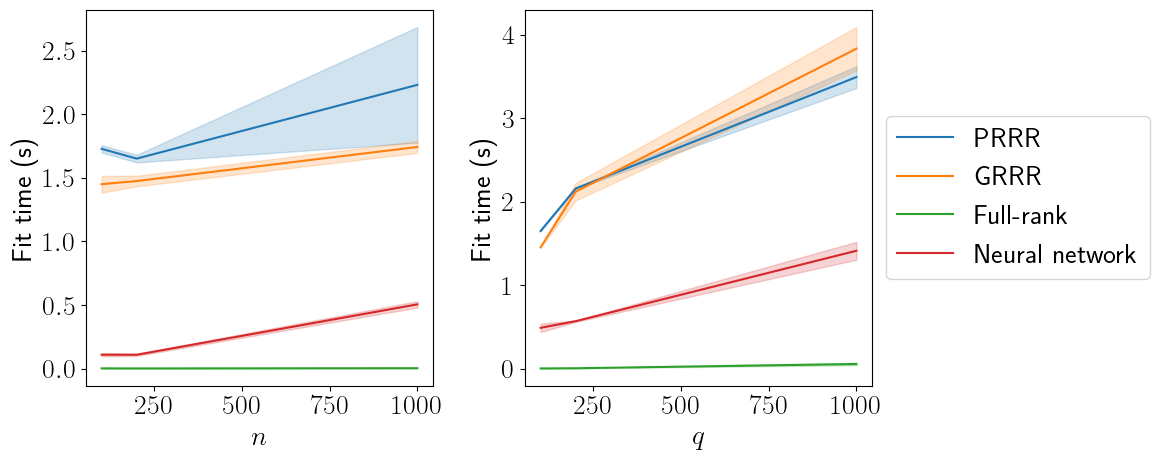

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.lineplot(data=results_df_n, x="variable", y="value", hue="method")
plt.xlabel(r"$n$")
plt.ylabel("Fit time (s)")
plt.legend([],[], frameon=False)

plt.subplot(122)
sns.lineplot(data=results_df_q, x="variable", y="value", hue="method")
plt.xlabel(r"$q$")
plt.ylabel("Fit time (s)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("./out/time_comparison.png")

plt.show()